In [2]:
import pandas as pd
import numpy as np
from preprocessing import preprocess_doc, merge, copyright, phrase_combination, replace_all
from tqdm import tqdm
from collections import Counter
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.test.utils import datapath
import gensim
from gensim.models.word2vec import Word2Vec
from numpy import dot
from numpy.linalg import norm
import sklearn
import imblearn
import itertools
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from matplotlib.pyplot import figure, text
from matplotlib import rcParams
%matplotlib inline

In [3]:
data=pd.read_csv('data.csv')

**Data preprocessing**

In [3]:
#discard items without abstracts
#remove copyright
#merge abstract, title and keywords 
data=data[~data.Abstract.isnull()].reset_index(drop=True)
data['AB']=data.Abstract.apply(lambda x:copyright(x))
data['Abs']=data[['AB','Title','Keywords']].apply(lambda x: merge(x).lower(), axis = 1)

In [4]:
#spacy pipeline including custom tokenizer, tagger, lemmatizer that performs in batches
data['doc']=preprocess_doc(data.Abs.to_list())

11909it [02:20, 85.01it/s] 


**Collocation: transform words into phrases with 2 passes**

In [4]:
#phrase_model
sentence=[eval(i) for i in data.doc.copy()]
phrases_model = Phrases(sentence, min_count=10, threshold=15,  delimiter='-',scoring='default',connector_words=ENGLISH_CONNECTOR_WORDS)
for phrase, score in phrases_model.find_phrases(sentence).items():
    print(phrase, score)

#threshold: represent a score threshold for forming the phrases (higher means fewer phrases)
#score: setting scores for the potential phraze
phrases_model.save("my_phrase_model.pkl") # save

sentiment-analysis 30.424172554230754
sentiment-classification 19.705036723715683
natural-language 185.47249290072608
processing-nlp 358.4157936794632
sentiment-polarity 39.65976055660173
different-aspect 15.170927564732875
recurrent-neural 653.2045112781955
network-rnn 17.678458583985098
convolutional-neural 1072.8555066079296
network-cnn 25.159237900576684
experiment-benchmark 16.544021482724947
social-media 21.992189464311007
article-examine 15.204122175796812
raise-concern 18.008820056222632
united-states 1369.423076923077
eat-disorder 893.2925271091933
inductive-thematic 48.97078715544189
blog-post 16.90956070735606
thematic-analysis 44.670526804906935
facebook-page 48.74913719943423
significant-difference 69.6114836401408
youtube-video 18.27180435407904
relatively-low 30.69396551724138
number-like 17.65892998042772
implication-future 16.367809488874187
highlight-importance 65.64883809523809
machine-learning 171.14773725047772
well-understanding 62.239534236977164
let-play 40.8612

european-parliament 614.4859660740665
discussion-thread 60.44228233115407
public-sector 15.668372206146762
probabilistic-graphical 546.7265228426395
drug-abuse 211.52287233405585
spanish-general 33.73428079242033
party-candidate 30.446917525854147
second-screen 63.77581332004322
trait-empathy 100.98933427097985
member-congress 25.616377131871293
graduate-student 58.839183283255934
box-office 5793.66192680776
trading-strategy 16.283338530298305
cross-modal 18529.913978494624
nus-wide 3426.007952286282
cross-media-retrieval 48.74913719943423
content-based-filtering 71.05145543003216
potentially-useful 28.20982844421163
supply-chain 2348.709890965732
sentiment-dictionary 16.554535530578917
heart-disease 70.53092129496991
pussy-riot 5345.167493796526
labor-intensive 346.73682092555333
negatively-impact 20.566678601265068
human-computer 26.510515882608903
digital-footprint 147.79787700850474
virtual-world 35.7408743985399
receiver-operate 965.6945923227796
jama-score 48.82925308851864
quit-

**Define seeds**

In [10]:
# apply collocation to the texts 
# note that input should be a list
data['coll'] = data.doc.apply(lambda x:phrases_model[x]).values 

In [11]:
# manually labelled methods from 200 randomly sampled texts
# apply the same preprocessing pipeline to these method terms 
data1=pd.read_csv('100samples.csv')
data1=data1.dropna(subset=['Method'])
def remove(doc):
    return doc.replace('-',' ')
method=[]
for i in set([j.strip() for i in data1.Method.to_list() for j in i.replace(',',';').split('; ') ]):
    method.append(i)   
method=[remove(' '.join(i)) for i in preprocess_doc(method)]

147it [00:00, 3609.60it/s]


In [13]:
# methods terms mined from wikipedia & machine learning method terms from Paperwithcode.com
# see notebook Method_scraping.ipynb for details 
with open('wiki_methods_0811.txt','r') as f:
    method_wiki=f.read().split('\n')
wiki_list=[' '.join(i).replace('-','') for i in preprocess_doc(method_wiki[:-1])]
ml_task=pd.read_csv('ml_tasks.csv')
ml_methods=pd.read_csv('ml_methods.csv')
ml_methods['full_coll'] = [remove(' '.join(i)) for i in preprocess_doc(ml_methods['full_name'].to_list())]
# generate a full list
full_list=ml_methods.full_coll.to_list()+ wiki_list

58it [00:00, 2402.38it/s]
1131it [00:00, 3166.81it/s]


In [14]:
# mined, manually validated methods
with open('new_method_mined.txt','r') as f:
    method_1=f.read().split(';\n')

**Improve collocation based on the method list**

In [23]:
# combine method lists
method_list=list(set(method+method_1))
method_list =[i.replace(' ','-') for i in method_list]

In [157]:
# write
with open('new_method_1202.txt','w+') as f:
    f.write(';\n'.join(sorted(list(set(method_list)))))

In [12]:
#transform the known method terms into phrases
#solve the issue of inappropriate/incomplete collocation generated by our phrase model 

method_list.sort(key=lambda x: len(x)) #sorted by length (roots first)
replace_dic = dict(zip([ j for i in method_list if len(i.split('-'))>1 for j in phrase_combination(i.replace('-',' '))], [' '+i+' ' for i in method_list if len(i.split('-'))>1 for j in phrase_combination(i.replace('-',' '))]))
data['docs']=data.coll.apply(lambda x:replace_all(' '.join(eval(x))+' ',replace_dic).split(' ')).values

In [187]:
# example: transform all these terms mentioning "neural network" with connectors "-" to "neural-network" 
phrase_combination('neural network')

['-neural-network-',
 '-neural-network ',
 '-neural network-',
 '-neural network ',
 ' neural-network-',
 ' neural-network ',
 ' neural network-',
 ' neural network ']

In [33]:
#the number of unique terms after preprocessing
articles = [eval(i)[:-1] for i in data['docs'].copy()]
term=[]
for i in range(11909):
    term+=articles[i]
len(Counter(term))

59086

In [34]:
#example
articles[0][:20]

['sentiment-analysis',
 'include',
 'aspect-level',
 'sentiment-classification',
 'important',
 'basic',
 'natural-language-processing',
 'nlp',
 'task',
 'aspect-level',
 'sentiment',
 'provide',
 'complete',
 'in-depth',
 'result',
 'word',
 'different',
 'contexts',
 'variably',
 'influence']

In [35]:
# most common terms
Counter(term).most_common(10)

[('social-media', 18487),
 ('twitter', 13159),
 ('user', 12598),
 ('data', 10415),
 ('study', 9516),
 ('information', 9089),
 ('tweet', 8855),
 ('online', 8397),
 ('post', 8008),
 ('social', 7725)]

In [36]:
len(term) # total number of remained terms after preprocessing

1446180

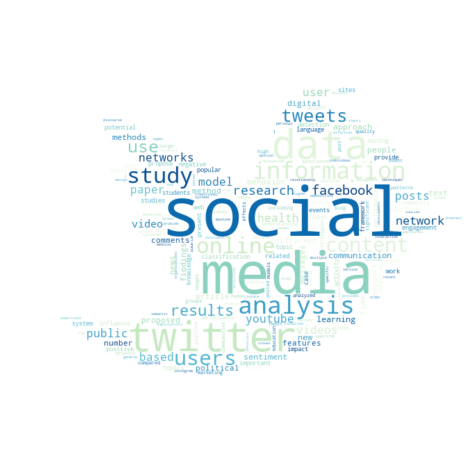

In [36]:
#corpus
from PIL import Image
count=Counter([i.replace(' ','-') for i in term])
mask = np.array(Image.open('twitter.jpg'))
wordcloud = WordCloud(width=800, height=400,mask=mask,max_font_size=120,min_font_size=5, max_words=200,colormap=matplotlib.cm.GnBu, background_color="white").generate_from_frequencies(dict(count))

# Display the generated wordcloud
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear' )
plt.axis("off")
plt.savefig('Corpus.png')
plt.show()

**Train w2v model**

In [4]:
# corpus
docs=[eval(i) for i in data['docs'].copy()]
#docs=[eval(i) for i in docs]

In [8]:
w2v = Word2Vec(docs,vector_size=300,workers=4,negative=20,sg=1,ns_exponent=0.75,window=5,min_count=1) 
# vector_size: dimientionality of the word vector
# window:how much Context
# min_count: ignore words lower than this frequency
# workers: Number CPU Cores to use for training in Parallel.
# iter: Depending on the size of your data you might want to run through your data more than once.
# negative: negative sampling will be used
# alpha: the initial learning rate

In [5]:
# save
w2v.save("word2vec_1202_count1.model")
w2v = Word2Vec.load("word2vec_1202_count1.model")

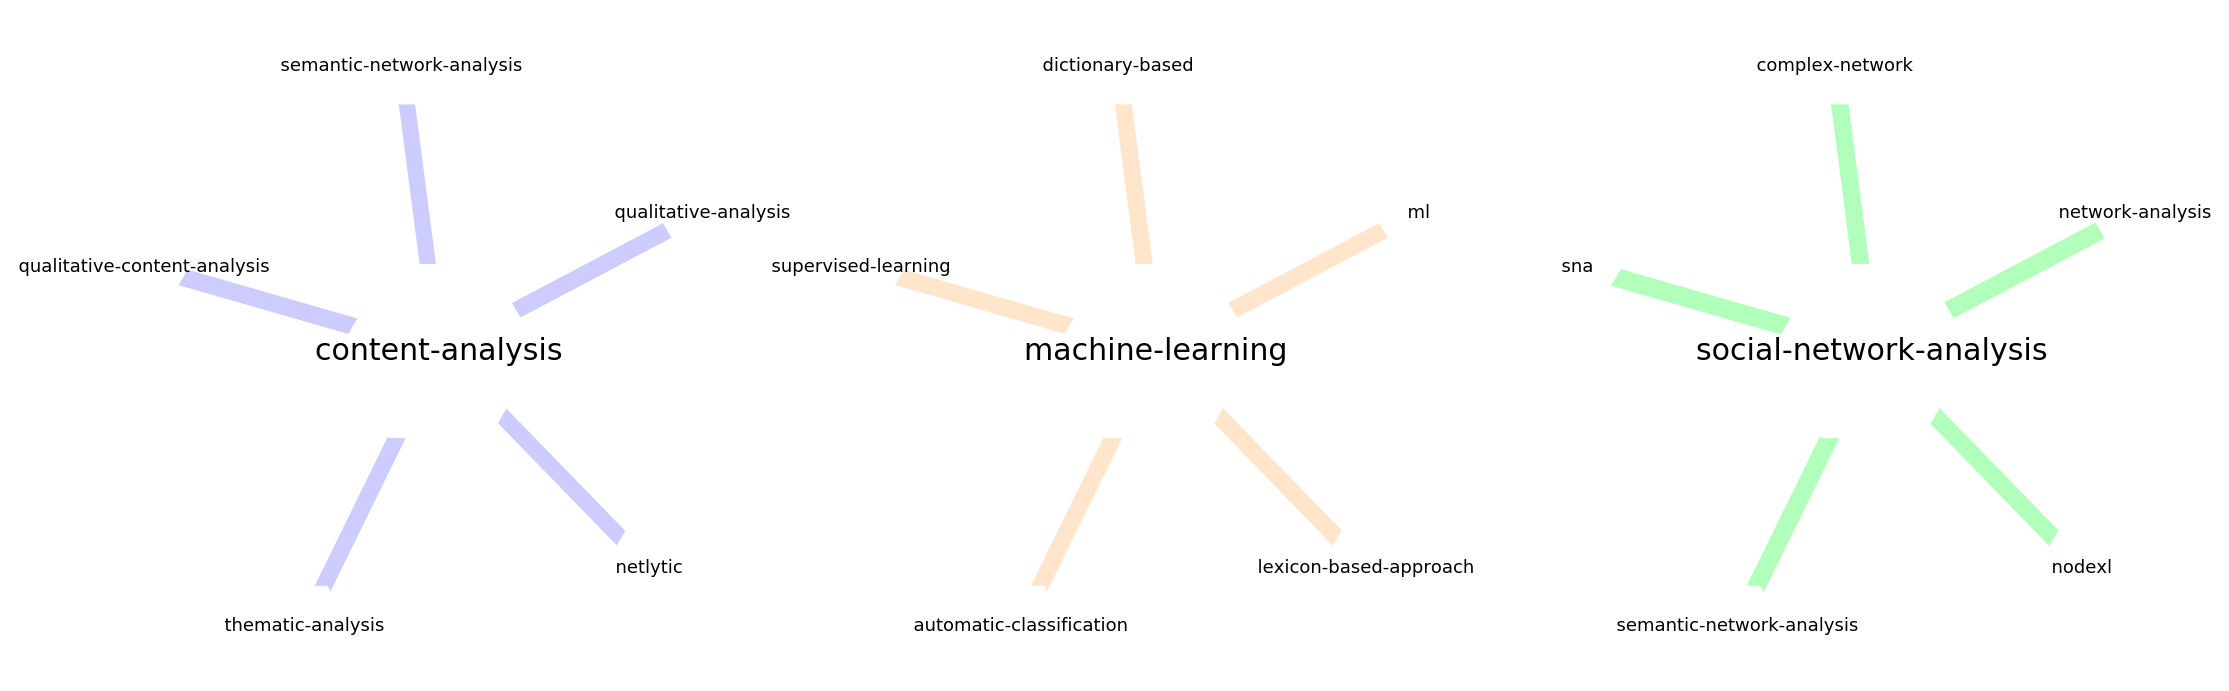

In [107]:
# graph illustration for finding the most similar terms based on cosine similarity

m_name= ['content-analysis', 'machine-learning', 'social-network-analysis']
colors= [['#ccccff', '#9999ff'], ['#ffe5cc', '#ffcc99'], ['#b2ffbb', '#60e56d']]

g=nx.DiGraph()
for i in range(2,7):    
    g.add_edge(1,i)
pos=nx.spring_layout(g)
#pos=force_pos(g)

rcParams['figure.figsize'] = 30,10
fig,ax= plt.subplots(nrows=1, ncols=3)
fig.tight_layout()

for method in range(len(m_name)):
    plt.subplot(1,3, method+1)
    ls=w2v.wv.most_similar(m_name[method])
    node_names = {}
    for i in range(2,7): 
        node_names[i]=ls[i-2][0]
    edge_width=np.array([j for i, j in ls[:5]])
    node_names[1]=m_name[method]
    nodes=nx.draw_networkx_nodes(g,pos,node_size=[8000*v for v in dict(g.degree()).values()], node_shape='H',node_color="white")

    #nodes.set_edgecolor(colors[method][1])
    #nodes.set_linewidth(15)
    nx.draw_networkx_edges(g,pos,width=np.exp(edge_width)*8,edge_color=colors[method][0],style='solid')
    d = dict(g.degree())
    for node, (x, y) in pos.items():
        text(x, y, '  '+node_names[node]+ '  ', fontsize=(d[node]+5)*3, ha='center', va='center')
    plt.axis('off')
    plt.savefig('query_1.png')

plt.show()

**Query expansion**

In [122]:
# Define search seeds and search via w2v.wv.most_similar
# firstly remove words without embeddings 
def notfound(term_list, model):
    ls=[]
    for i in term_list:
        try:
            model.wv[i]
            ls.append(i)
        except:
            pass
    return ls
method_ls=notfound(method_list, w2v)
seeds = [i.replace(' ','-') for i in set(method_ls)]
#lexicon = []
done = set()

In [182]:
# custom loop for query expansion and manual validation
while len(done)<=182:
    seed = seeds.pop(0) #index and remove the first item
    can=0 #candicate
    ls=0 # count
    done.add(seed)
    similar = w2v.wv.most_similar(seed)
    #if seed in w2v.wv:
    #    similar = w2v.wv.most_similar(seed)
    #else:
    #    done.add(seed)
    #    lexicon.append(seed)
    #    continue
    for candidate,score in similar:
        ls+=1
        if candidate in method_ls or candidate in seeds:
            pass
        else:
            print(candidate,score)
            i = input('Include in lexicon? Press y else enter')
            if i=='y':
                seeds.append(candidate)
                can +=1
        if ls>=6:
            end = input('Do you wish to continue? Press enter else n')
            if end=='n':
                break

transdiagnostic 0.9425782561302185
Include in lexicon? Press y else entern
postmenopausal 0.9369322657585144
Include in lexicon? Press y else entern
two-arm 0.9338061809539795
Include in lexicon? Press y else entern
walking 0.9309273958206177
Include in lexicon? Press y else entern
rct 0.9290927648544312
Include in lexicon? Press y else entern
Do you wish to continue? Press enter else nn


In [188]:
new_seed= list(set(seeds)) + list(set(method_ls))
#manual label + mined +query expansion 
with open('new_method_1220.txt','w+') as f:
    f.write(';\n'.join(list(set(new_seed))))
# save method list 
df=pd.DataFrame(columns=['Manual_labelled','Mined',"Query_expansion"])
df.at[0,'Manual_labelled']= '; '.join(sorted(method))
df.at[0,'Mined']= '; '.join(sorted(list(set(method_1))))
df.at[0,'Query_expansion']= remove('; '.join(sorted(list(set(seeds)))))
df.to_csv('methods_list.csv',index=False)